<a href="https://colab.research.google.com/github/Ana-PPS/data-and-analytcs/blob/MVP_II/MVPb_SprintII_AnaPaulaSalgado_entrega.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PUC Rio: Pós Graduação em Ciência de Dados e Analytics**

**MVP Sprint II: Machine Learning & Analytics**
**Parte b**

Aluna: Ana Paula Pinheiro Salgado

Julho/2023

## Seção I: Introdução
**Classificador de imagens multiclasse - Animais**

**Contexto:** Temos um conjunto de imagens que representam 4 categorias de animais: vaca, galinha, cavalo e elefante. O objetivo deste notebook é criar um modelo de visão computacional que consiga classificar uma imagem dentre essas categorias.

**Estrutura:** O notebook encontra-se dividido da seguinte forma:

- Importação das bibliotecas
- Acesso e tratamento dos dados que serão a entrada do modelo de deep learning
- Configuração do modelo de deep learning usando uma rede neural convolucional simples com Keras
- Treinamento do modelo de deep learning
- Execução do modelo de deep learning treinado
- Avaliação do modelo de deep learning
- Exportação do modelo de deep learning
- Teste do modelo exportado

**Dataset:** A partir do dataset original, baixado do Kaggle (https://www.kaggle.com/datasets/alessiocorrado99/animals10), foram selecionadas apenas 4 pastas de imagens de forma a otimizar o tempo de execução do MVP.

## Importando as bibliotecas necessárias para executar o notebook
(Serão utilizadas as bibliotecas pandas e numpy, para a manipulação dos dados; matplotlib, para geração de gráficos; os, para manipulação de pastas e diretórios e bibliotecas voltadas para Machine e Deep Learning, tais como Keras, Tensor Flow e Scikit-Learn)


In [99]:
# para usar o Google Drive
!pip install -q gdown
import gdown
from google.colab import drive

#para acessar e manipular arquivos, diretórios e estrutra de dados
import os
import shutil
from zipfile import ZipFile
import pandas as pd

# cálculos numéricos e operações matemáticas e trabalhar com números aleatórios
import numpy as np
import math
import random

# bibliotecas do keras para pré-processamento, modelos convolucionais e otimizadores dos modelos
!pip install -q tensorflow
!pip install -q keras
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers,models,Model
from tensorflow.keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

# sckit-learn para pré-processamento e uso de métricas em machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight, shuffle
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
#import sklearn.metrics as skm

# plotagem de gráficos, visualizações e imagens
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from skimage.io import imread
from skimage.transform import resize

# iterações
import itertools

# para uso de data e hora
from datetime import datetime

## Acessando e tratando os dados que serão a entrada do modelo de deep learning

In [38]:
# Baixando a pasta compactada para o notebook
file_id = "1bg_JhbuWv2lCCDyrfGI2yr5dROxbijYQ"

folder_path = f"https://drive.google.com/uc?id={file_id}"
output = "4animais.zip"
gdown.download(folder_path, output)

Downloading...
From: https://drive.google.com/uc?id=1bg_JhbuWv2lCCDyrfGI2yr5dROxbijYQ
To: /content/4animais.zip
100%|██████████| 174M/174M [00:00<00:00, 179MB/s]


'4animais.zip'

In [39]:
# Descompactando o arquivo
with ZipFile('4animais.zip', 'r') as zip_object:
  zip_object.extractall()

In [40]:
# Reunindo todos os arquivos em uma pasta para transformar em um dataset

path = "/content/"

classes = ['vaca', 'galinha', 'elefante', 'cavalo']

foldernames = os.listdir(path)

data = {"images": [], "animal": []}

for folder in classes:
    folderpath = os.path.join(path, folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["images"].append(fpath)
        data["animal"].append(folder)


df = pd.DataFrame(data)

In [91]:
print(df.head)
print(df.shape)

<bound method NDFrame.head of                                                  images  animal
0     /content/vaca/OIP-GXDFTn7XV7Mj3Z3qe42TzwHaFj.jpeg    vaca
1     /content/vaca/OIP-8fITi6odS5d7nFFrt3ZVkgHaEK.jpeg    vaca
2     /content/vaca/OIP-p4ifyEpq_1CNleQ0xQ9oNgHaHa.jpeg    vaca
3     /content/vaca/OIP-8Ix7idR6MNbiFTWAMxjUdwHaEU.jpeg    vaca
4     /content/vaca/OIP-vKiBGH0ARNIXUHnNFM048wHaFU.jpeg    vaca
...                                                 ...     ...
9028  /content/cavalo/OIP-L__JnPZRytR00r0S3PXOrwHaNK...  cavalo
9029  /content/cavalo/OIP-WZHi3EwD7cCjCDhP3kec9gHaLH...  cavalo
9030  /content/cavalo/OIP-gaEDIBAwmgABgflnIWR1XQHaE-...  cavalo
9031  /content/cavalo/OIP-oKwZqGUiJvFupyGSEClj3QHaGC...  cavalo
9032  /content/cavalo/OIP-Dy5E33g3dBaoh5HbiPiLbQHaK3...  cavalo

[9033 rows x 2 columns]>
(9033, 2)


In [41]:
#Resumo do dataset criado

print("Tamanho do dataset: ", df.shape)
print("_______________________________________")
print("Valores null: ")
print(df.isnull().sum())
print("_______________________________________")
print("Valores únicos: ")
print(df.nunique())

print("_______________________________________")
print("Qnt de imagens por categoria : ")
print(df.animal.value_counts())

print("_______________________________________")
print("Informação do dataset: ")
print(df.info())

Tamanho do dataset:  (9033, 2)
_______________________________________
Valores null: 
images    0
animal    0
dtype: int64
_______________________________________
Valores únicos: 
images    9033
animal       4
dtype: int64
_______________________________________
Qnt de imagens por categoria : 
galinha     3098
cavalo      2623
vaca        1866
elefante    1446
Name: animal, dtype: int64
_______________________________________
Informação do dataset: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9033 entries, 0 to 9032
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  9033 non-null   object
 1   animal  9033 non-null   object
dtypes: object(2)
memory usage: 141.3+ KB
None


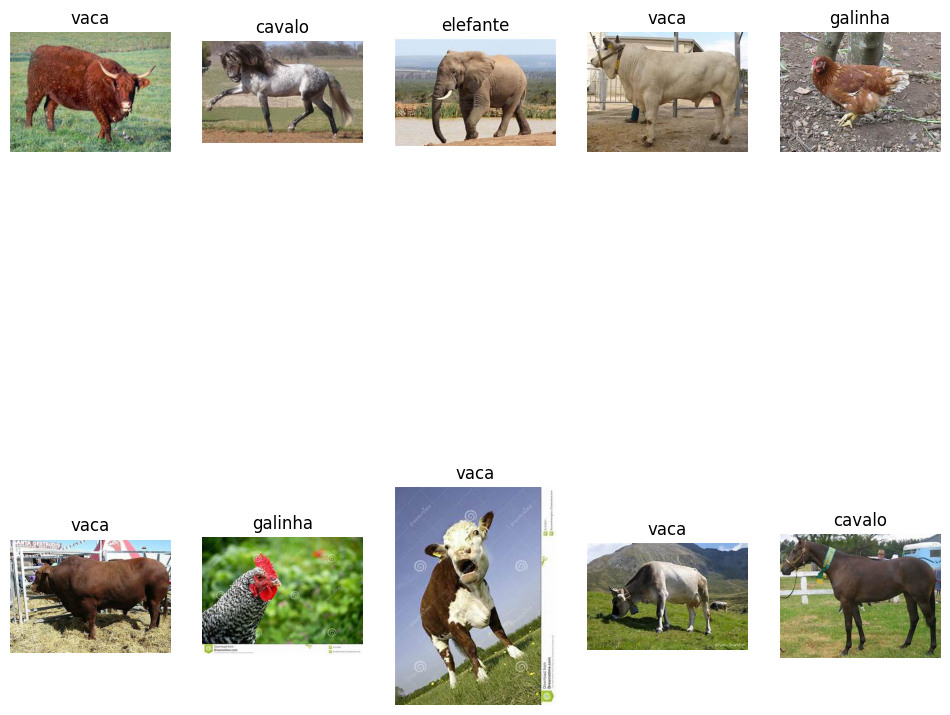

In [42]:
#Visualizando algumas imagens do conjunto de dados
fig = plt.gcf()
fig.set_size_inches(3*4, 3*4)
for i, row in df.sample(n=10).reset_index().iterrows():
    plt.subplot(2,5,i+1)
    image_path = row['images']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["animal"])
    plt.axis('off')
plt.show()

In [96]:
# Separação do dataframe em treino, teste e validação
df_train, Temp_df = train_test_split(df, train_size=0.7, random_state=13, shuffle=True)
df_test, df_val = train_test_split(Temp_df, test_size=0.6, random_state=30, shuffle=True)

In [97]:
#Resumo da separação do conjunto de dados
print("#########Train##############")
print(df_train.head())
print(df_train.shape)
print("#########Test###############")
print(df_test.head())
print(df_test.shape)
print("#########Validação###############")
print(df_val.head())
print(df_val.shape)

#########Train##############
                                                 images    animal
4191  /content/galinha/OIP-_EVbG8aIl95u_WOlYf3k-QHaD...   galinha
6599  /content/cavalo/OIP-Btga3yh8ILdqwjZhJoV_zAHaFj...    cavalo
5582  /content/elefante/OIP-1msK2YztfEyXIlxlUTonPgHa...  elefante
7470  /content/cavalo/OIP-mQ9s7HHCvQvkWt_z5yDWUAAAAA...    cavalo
8510  /content/cavalo/OIP-GogV-ojINVQWDgPkECUNGgHaE6...    cavalo
(6323, 2)
#########Test###############
                                                 images    animal
6383  /content/elefante/OIP-mmNjPTEi-JVhv4aKiYpLGQHa...  elefante
6106  /content/elefante/OIP-7LSiJVl5T9JBJshmZXWNgQAA...  elefante
6823  /content/cavalo/OIP-KgwxiD45b_uxH1E5la6xeQHaGN...    cavalo
5102  /content/elefante/OIP-jLkVAsM3KcDx6MHP850cfAHa...  elefante
7155  /content/cavalo/OIP-6Nq1ZBalkb6pcX06ZoA8OwHaFh...    cavalo
(1084, 2)
#########Validação###############
                                                 images    animal
8026  /content/cavalo/OIP-xQ-M

##  Preparação dos dados

`ImageDataGenerator` é uma classe utilitária fornecida pelo TensorFlow para aumentar e pré-processar dados de imagens. É comumente usada em tarefas de deep learning, especialmente para classificação de imagens, para gerar imagens aumentadas (data augmentation) sob demanda durante o treinamento do modelo.

O Data Augmentation aplica transformações aleatórias nas imagens existentes, o que ajuda a evitar overfitting e torna o modelo mais robusto, expondo-o a uma variedade maior de variações nas imagens.


In [45]:
# Definindo o tamanho do batch, a dimensão das imagens e a quantidade de épocas
batch_size = 32
img_height = 224
img_width = 224
num_classes = 4
epochs = 30

In [46]:
train_datagen=ImageDataGenerator(rescale=1./255,
                             rotation_range=40,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

val_datagen=ImageDataGenerator(rescale=1./255)

test_datagen=ImageDataGenerator(rescale=1./255)


train_generator=train_datagen.flow_from_dataframe(
    dataframe=df_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    x_col='images',
    y_col='animal',
    color_mode ='rgb',
    seed = 13,
    shuffle=False
    )

val_generator=val_datagen.flow_from_dataframe(
    dataframe=df_val,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    x_col='images',
    y_col='animal',
    color_mode ='rgb',
    shuffle=False
    )

test_generator=test_datagen.flow_from_dataframe(
    dataframe = df_test,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    x_col='images',
    y_col='animal',
    color_mode ='rgb',
    shuffle=False)

Found 6323 validated image filenames belonging to 4 classes.
Found 1626 validated image filenames belonging to 4 classes.
Found 1084 validated image filenames belonging to 4 classes.


## Seção III: Configuração do Modelo de Deep Learning

### Configuração de um modelo de deep learning usando uma rede neural convolucional (CNN) simples com a biblioteca Keras

Aqui foi especificada uma `camada convolucional 2D` que possui 32 filtros(depois 64, 128 e 256) e função de ativação `ReLU`. Na sequência é adicionada uma camada `softmax` com a mesma função de ativação.  O parâmetro `input_shape` define a forma das imagens de entrada para a rede.

In [47]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height,img_width,3)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [48]:
# Resumindo o modelo que será utilizado
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

### Treinamento do modelo de deep learning

#### Compilação do modelo Keras com as configurações do treinamento.

`optimizer='adam'`: especifica o otimizador a ser usado durante o treinamento.

`loss='categorical_crossentropy'`: especifica a função de perda a ser usada durante o treinamento. Para problemas de classificação multiclasse, onde a variável alvo tem mais de duas categorias, a perda categórica de entropia cruzada é freqüentemente empregada.

`metrics=['accuracy']`: especifica as métricas de avaliação a serem usadas durante o treinamento e o teste.

In [49]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)

Epoch 1/30
198/198 [==============================] - 86s 423ms/step - loss: 1.2963 - accuracy: 0.4395 - val_loss: 1.0044 - val_accuracy: 0.5855
Epoch 2/30
198/198 [==============================] - 84s 424ms/step - loss: 0.9517 - accuracy: 0.6011 - val_loss: 0.9904 - val_accuracy: 0.6224
Epoch 3/30
198/198 [==============================] - 84s 422ms/step - loss: 0.8400 - accuracy: 0.6592 - val_loss: 0.7527 - val_accuracy: 0.7023
Epoch 4/30
198/198 [==============================] - 83s 419ms/step - loss: 0.7624 - accuracy: 0.6962 - val_loss: 0.7171 - val_accuracy: 0.6986
Epoch 5/30
198/198 [==============================] - 83s 420ms/step - loss: 0.7274 - accuracy: 0.7136 - val_loss: 0.6715 - val_accuracy: 0.7392
Epoch 6/30
198/198 [==============================] - 83s 420ms/step - loss: 0.6863 - accuracy: 0.7288 - val_loss: 0.7673 - val_accuracy: 0.7005
Epoch 7/30
198/198 [==============================] - 85s 427ms/step - loss: 0.6339 - accuracy: 0.7536 - val_loss: 0.7268 - val_ac

#### Visualização de métricas da avaliação do modelo treinado

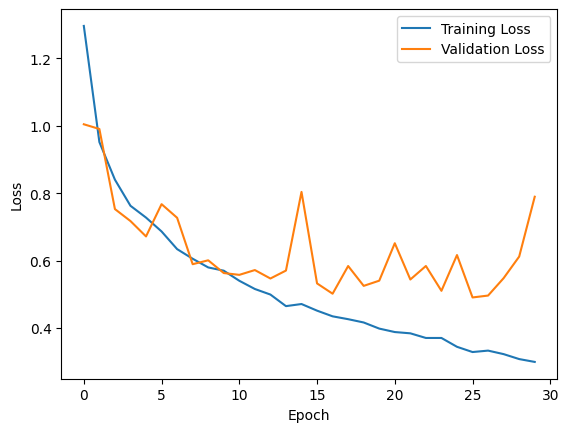

In [98]:
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

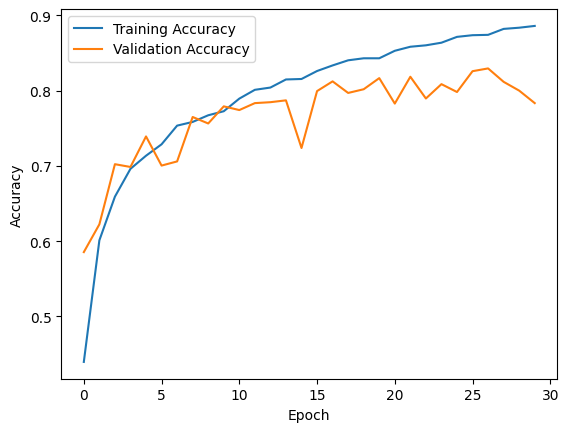

In [101]:
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

O modelo na primeira arquitetura parece começar a apresentar overfitting, dado que a acurácia tende a um resultado bem superior no conjunto de treinamento, com tendência inversa no conjunto de validação. Começando a apresentar divergência de resultados a partir da 10ª época.

Para tentar melhorar a generalização e reduzir overfitting, será aplicado algumas camadas de dropout e uma camada Flatten para transformar os dados em um único vetor, preparando-os para camada Densa posterior.

#### Adaptação do 1º modelo

In [102]:
model = keras.models.Sequential([
    keras.layers.Dropout(0.25, input_shape=(img_height,img_width, 3), seed = 13),
    keras.layers.Conv2D(32, (3,3), padding='same', activation='relu')),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.25)
    keras.layers.Dense(32, activation='relu')
    keras.layers.Dense(num_classes, activation='softmax')
])

SyntaxError: ignored

#### Salvando o Modelo para uso posterior

para uso posterior, não exigido no check list

In [ ]:
# obtendo data e hora atual
#now = datetime.now()

# Definição do formato
#formato_hora = %Y-%m-%dT%H%M

# Converte a data e hora em uma string com formato específico
#datetime_formatado = now.strftime(formato_hora)

# Mount Google Drive
#drive.mount('content', force_remount=True)

#Defineo caminho do diretório para salvar o modelo
#save_path = 'content'

#nome_modelo = 'trained_model_' + datetime_formatado + '.h5'

# Salva o modelo
#model.save(save_path + name_model)


## 5. Execução do modelo de deep learning treinado no teste_generator

#### Visualização de métricas da avaliação do modelo

In [85]:
# Fazendo as previsões no conjunto de teste usando o test_generator
y_pred = model.predict(test_generator)

# Convertendo as previsões de probabilidades para os rótulos
y_pred_labels = np.argmax(y_pred, axis=1)
y_pred_labels = [class_names[label] for label in y_pred_labels]

# Obtendo os rótulos verdadeiros do conjunto de teste
y_true_labels = df_test['animal'].tolist()

# Calculando as métricas
accuracy = skm.accuracy_score(y_true_labels, y_pred_labels)
precision = skm.precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = skm.recall_score(y_true_labels, y_pred_labels, average='weighted')
f1score = skm.f1_score(y_true_labels, y_pred_labels, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1score)

34/34 [==============================] - 4s 97ms/step
Accuracy:  0.11162361623616236
Precision:  0.1056401395834871
Recall:  0.11162361623616236
F1 Score:  0.10447089518925227


In [88]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta função imprime e plota a matriz de confusão.
    A normalização pode ser aplicada definindo `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão sem normalização')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Label real')
    plt.xlabel('Label predito')

Matriz de confusão sem normalização


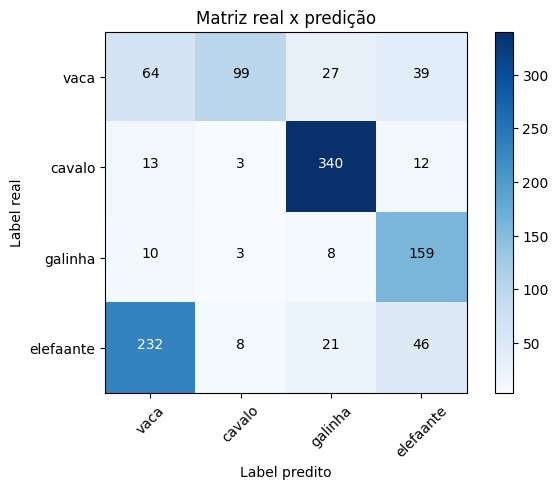

In [89]:
cnf_matrix = confusion_matrix(y_true_labels, y_pred_labels, labels=classes)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=['vaca', 'cavalo', 'galinha', 'elefante'],
                      normalize= False,
                      title='Matriz real x predição')

In [77]:
# Calculando as métricas
accuracy = skm.accuracy_score(y_true, y_pred)
precision = skm.precision_score(y_true, y_pred, average='weighted')
recall = skm.recall_score(y_true, y_pred, average='weighted')
f1score = skm.f1_score(y_true, y_pred, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1score)

ValueError: ignored

Matriz de confusão para identificar onde o modelo de deep learning acertou e errou na classificação das imagens de teste

In [69]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=['vaca', 'cavalo', 'galinha', 'elefaante'],
                      normalize= False,
                      title='Matriz real x predição')

ValueError: ignored

## 7. Exportação do modelo de deep learning para posterior uso

Salvando o modelo de deep learning que foi treinado

In [ ]:
# obtendo a data e hora atual
now = datetime.now()

# Definição do formato
format = '%Y-%m-%dT%H%M'

# Converter a data e hora em uma string com o formato especificado
formatted_datetime = now.strftime(format)

path_model = 'datasets/house/trained_models'

name_model = 'trained_model_' + formatted_datetime + '.h5'

# salvando o modelo
model.save("%s/%s" % (path_model, name_model))
print("Modelo salvo com o nome: ", name_model)

## 8. Teste do modelo exportado

Carregando o modelo salvo

In [ ]:
loaded_model = keras.models.load_model("%s/%s" % (path_model, name_model))
print("Modelo %s carregado com sucesso" % (name_model))

Executando o modelo exportado para acompanhar as classificações de cada uma das imagens de teste

In [ ]:
parent_dir = 'datasets/house/test'
count_images = 0
class_names = ['bath',
               'bed',
               'din',
               'kitchen',
               'living']
y_pred = list()
y_true = list()

# Percorrendo a pasta onde estão salvas as imagens de teste
for subdir, dirs, files in os.walk(parent_dir):

    for file in files:

        if file.endswith('.png') or file.endswith('.jpg'):

            count_images+=1
            split_path = os.path.join(subdir, file).split('/')
            label = split_path[3]
            y_true.append(label)

            img_path = os.path.join(subdir, file)
            display(Image(filename=img_path, width=300))

            img = image.load_img(img_path, target_size=(img_height,img_width))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = x.astype('float32') / 255.0

            # Previsão
            prediction = loaded_model.predict(x)

            # Printando as saídas do modelo
            predicted_class = np.argmax(prediction[0])
            probability = prediction[0][predicted_class]
            y_pred.append(class_names[predicted_class])
            print("Label:", label)
            print("Previsão:", class_names[predicted_class])
            print("Probabilidade:", probability)
            print("\n")